# Figure 7

This notebook is used for the recreation of Figure 7 in the paper. This figure shows how models trained on different datasets rely on background signals in making correct classifications. In our reproduction, the models trained in Figure 5 are used here.

In [ ]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
import json
import torchvision
import numpy as np
import torch
import torchvision.models as models
import pandas as pd

In [ ]:
#Function that converts raw data into a PyTorch DataLoader object
def getDataLoader(preprocess, datadir = 'mixed_same/val'):
    imgFolder = ImageFolder(datadir, transform=preprocess)
    testloader = DataLoader(imgFolder, batch_size=1, shuffle=False)
    return testloader

In [ ]:
#Returns list of whether each observation was predicted correctly
def listOfCorrectPreds(model, data):
  correct = []

  for input, label in data:
    input, label = input.to('cuda:0'), label.to('cuda:0')
    output = model(input).detach()
    output = torch.argmax(output, dim=1)
    result = int((output==label).to('cpu').detach().numpy()[0])
    correct.append(result)

  return correct

In [ ]:
#Create the dataframe used to plot Figure 7
def createDF(index_name, original_preds, mixed_rand_preds, only_bg_t_preds):
  #Create dataframe
  df = pd.DataFrame({
      'original': original_preds,
      'mixed_rand': mixed_rand_preds,
      'only_bg_t': only_bg_t_preds
  })
  df['bg_required'] = ((df.original == 1) & (df.mixed_rand == 0) & (df.only_bg_t == 1)).astype(int)
  df['bg_fools'] = ((df.original == 0) & (df.mixed_rand == 1) & (df.only_bg_t == 0)).astype(int)
  df['bg_fg_required'] = ((df.original == 1) & (df.mixed_rand == 0) & (df.only_bg_t == 0)).astype(int)
  df['bg_fg_fools'] = ((df.original == 0) & (df.mixed_rand == 1) & (df.only_bg_t == 1)).astype(int)
  df['bg_irrelevant'] = (df.original == df.mixed_rand).astype(int)
  df = df.drop(labels=['original','mixed_rand','only_bg_t'], axis=1)
  df = pd.DataFrame(df.sum(), columns=[index_name]).transpose()
  cols = ['bg_irrelevant', 'bg_required','bg_fools','bg_fg_required','bg_fg_fools']
  df = df[cols]

  return df

In [ ]:
!unzip drive/MyDrive/ReproducabilityChallenge/only_bg_t.zip
!unzip drive/MyDrive/ReproducabilityChallenge/mixed_rand.zip
!unzip drive/MyDrive/ReproducabilityChallenge/original.zip

Streaming output truncated to the last 5000 lines.
  inflating: original/val/04_carnivore/n02447366_05155.JPEG  
  inflating: __MACOSX/original/val/04_carnivore/._n02447366_05155.JPEG  
  inflating: original/val/04_carnivore/n02130308_19433.JPEG  
  inflating: __MACOSX/original/val/04_carnivore/._n02130308_19433.JPEG  
  inflating: original/val/04_carnivore/n02117135_04940.JPEG  
  inflating: __MACOSX/original/val/04_carnivore/._n02117135_04940.JPEG  
  inflating: original/val/04_carnivore/n02120079_45175.JPEG  
  inflating: __MACOSX/original/val/04_carnivore/._n02120079_45175.JPEG  
  inflating: original/val/04_carnivore/n02447366_34872.JPEG  
  inflating: __MACOSX/original/val/04_carnivore/._n02447366_34872.JPEG  
  inflating: original/val/04_carnivore/n02445715_04601.JPEG  
  inflating: __MACOSX/original/val/04_carnivore/._n02445715_04601.JPEG  
  inflating: original/val/04_carnivore/n02114548_02565.JPEG  
  inflating: __MACOSX/original/val/04_carnivore/._n02114548_02565.JPEG  
  in

In [ ]:
#Models will be evaluated using GPU on Google Colab
device = 'cuda:0'

# Only_BG_T

In [ ]:
#Get the original dataset
# convert each image to tensor format
preprocess = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
original = getDataLoader(preprocess = preprocess, datadir = 'original/val')
mixed_rand = getDataLoader(preprocess = preprocess, datadir = 'mixed_rand/val')
only_bg_t = getDataLoader(preprocess = preprocess, datadir = 'only_bg_t/val')

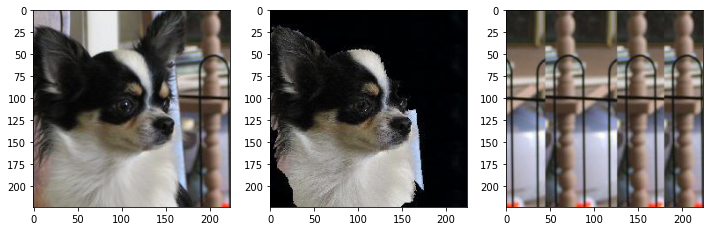

In [ ]:
#Example images
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
images1, _ = next(iter(original))
im = np.asarray(images1[0])
im = np.moveaxis(im, 0, -1)
ax[0].imshow(im)
images2, _ = next(iter(mixed_rand))
im = np.asarray(images2[0])
im = np.moveaxis(im, 0, -1)
ax[1].imshow(im)
images3, _ = next(iter(only_bg_t))
im = np.asarray(images3[0])
im = np.moveaxis(im, 0, -1)
ax[2].imshow(im)
plt.show()

In [ ]:
#Load the ResNet18 model that was trained on Only-BG-T for Figure 5
r18 = models.resnet18(pretrained = False).to(device)
r18.fc = nn.Sequential(
               nn.Linear(r18.fc.in_features, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 9)).to(device)
r18.load_state_dict(torch.load("drive/MyDrive/ReproducabilityChallenge/only_bg_t_resnet18_sgd.weights"))
r18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#Get array of correct/incorrect predictions of the model on each test set
original_preds = listOfCorrectPreds(r18, original)
mixed_rand_preds = listOfCorrectPreds(r18, mixed_rand)
only_bg_t_preds = listOfCorrectPreds(r18, only_bg_t)

In [ ]:
#Create the summary dataframe
onlybgt_df = createDF('only_bg_t', original_preds, mixed_rand_preds, only_bg_t_preds)

In [ ]:
onlybgt_df

,bg_irrelevant,bg_required,bg_fools,bg_fg_required,bg_fg_fools
only_bg_t,2616,608,114,621,91


In [ ]:
#Check all 4050 images are accounted for
print(onlybgt_df.sum(axis=1)[0] == 4050)

True


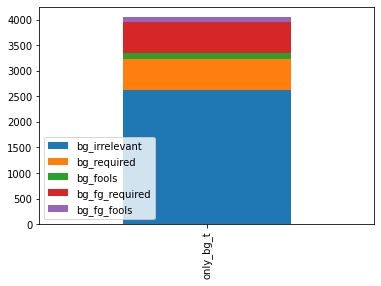

In [ ]:
onlybgt_df.plot.bar(stacked=True)

# Mixed-Rand

In [ ]:
#Get the original dataset
# convert each image to tensor format
preprocess = transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])
original = getDataLoader(preprocess = preprocess, datadir = 'original/val')
mixed_rand = getDataLoader(preprocess = preprocess, datadir = 'mixed_rand/val')
only_bg_t = getDataLoader(preprocess = preprocess, datadir = 'only_bg_t/val')

In [ ]:
#Load the ResNet34 model that was trained on Mixed-Rand for Figure 5
r34 = models.resnet34(pretrained = False).to(device)
r34.fc = nn.Sequential(
               nn.Linear(r34.fc.in_features, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 9)).to(device)
r34.load_state_dict(torch.load("drive/MyDrive/ReproducabilityChallenge/mixed_rand_resnet34_20_epochs_adam.weights"))
r34.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#Get array of correct/incorrect predictions of the model on each test set
original_preds = listOfCorrectPreds(r34, original)
mixed_rand_preds = listOfCorrectPreds(r34, mixed_rand)
only_bg_t_preds = listOfCorrectPreds(r34, only_bg_t)

In [ ]:
#Create the summary dataframe
mixedrand_df = createDF('mixed_rand', original_preds, mixed_rand_preds, only_bg_t_preds)

In [ ]:
mixedrand_df

,bg_irrelevant,bg_required,bg_fools,bg_fg_required,bg_fg_fools
mixed_rand,3060,68,511,340,71


In [ ]:
#Check all 4050 images are accounted for
print(mixedrand_df.sum(axis=1)[0] == 4050)

True


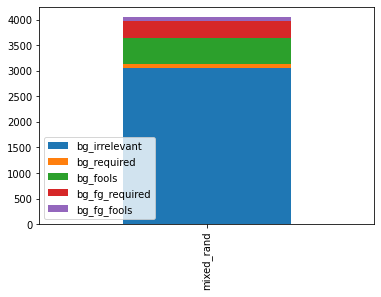

In [ ]:
mixedrand_df.plot.bar(stacked=True)

# Original

In [ ]:
# convert each image to tensor format
preprocess = transforms.Compose([
  transforms.Resize(256), 
  transforms.CenterCrop(224), 
  transforms.ToTensor(), 
  transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
  )])
original = getDataLoader(preprocess = preprocess, datadir = 'original/val')
mixed_rand = getDataLoader(preprocess = preprocess, datadir = 'mixed_rand/val')
only_bg_t = getDataLoader(preprocess = preprocess, datadir = 'only_bg_t/val')

In [ ]:
#Load the ResNet18 model that was trained on Original for Figure 5
model_18 = models.resnet18(pretrained=True).to(device)
model_18.avgpool = nn.AdaptiveAvgPool2d((1,1))
model_18.fc = nn.Linear(512, 9).to(device)
model_18.load_state_dict(torch.load("drive/MyDrive/ReproducabilityChallenge/original_resnet18_5_epoch.weights"))
model_18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#Get array of correct/incorrect predictions of the model on each test set
original_preds = listOfCorrectPreds(model_18, original)
mixed_rand_preds = listOfCorrectPreds(model_18, mixed_rand)
only_bg_t_preds = listOfCorrectPreds(model_18, only_bg_t)

In [ ]:
#Create the summary dataframe
original_df = createDF('original', original_preds, mixed_rand_preds, only_bg_t_preds)

In [ ]:
original_df

,bg_irrelevant,bg_required,bg_fools,bg_fg_required,bg_fg_fools
original,3196,405,28,395,26


In [ ]:
#Check all 4050 images are accounted for
print(original_df.sum(axis=1)[0] == 4050)

True


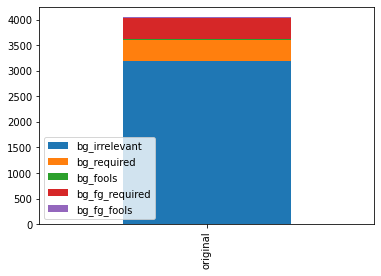

In [ ]:
original_df.plot.bar(stacked=True)

# Create Figure 7

In [ ]:
#Combine all resulting dataframes
figure7_df = pd.concat([mixedrand_df, original_df, onlybgt_df])

In [ ]:
figure7_df

,bg_irrelevant,bg_required,bg_fools,bg_fg_required,bg_fg_fools
mixed_rand,3060,68,511,340,71
original,3196,405,28,395,26
only_bg_t,2616,608,114,621,91


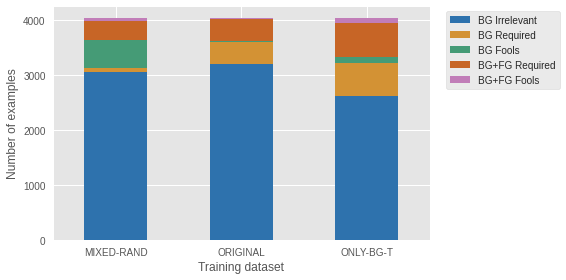

In [ ]:
#Create Figure 7 plot
plt.style.use('ggplot')
ax = figure7_df.plot.bar(stacked=True, color=['#2e72ad','#d39234','#459b76','#c76526','#c17db8'], figsize=(8, 4))
ax.set_xlabel('Training dataset')
ax.set_ylabel('Number of examples')
ax.set_xticklabels(labels=['MIXED-RAND','ORIGINAL','ONLY-BG-T'])
plt.xticks(rotation=360)
plt.yticks([0, 1000, 2000, 3000, 4000])
plt.legend(labels=['BG Irrelevant','BG Required','BG Fools','BG+FG Required','BG+FG Fools'], frameon=True,bbox_to_anchor=(1.03, 1), loc='upper left')
plt.tight_layout()
plt.savefig('figure7.png', dpi=500)
plt.show()